In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image
from sklearn.model_selection import train_test_split

In [4]:
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
root="/content/drive/MyDrive/Dataset/Corn_Maize_dataset/data"
categories=os.listdir(root)
categories

['Blight', 'Healthy', 'Gray_Leaf_Spot', 'Common_Rust']

Creating Image and Label Lists

In [7]:
images = []
labels = []
for category in categories:
    directory = root +"/" + category + '/'
    for image_file in os.listdir(directory):
        images.append(directory + image_file)
        labels.append(category)

Creating a DataFrame

In [8]:
images = pd.Series(images, name="Image")
labels = pd.Series(labels, name="Quality")
data=pd.concat([images,labels], axis=1)
data.head()

,Image,Quality
0,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight
1,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight
2,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight
3,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight
4,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight


Shuffling the DataFrame

In [9]:
data=data.sample(frac=1).reset_index(drop = True)
data.head()

,Image,Quality
0,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Healthy
1,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Common_Rust
2,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight
3,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Blight
4,/content/drive/MyDrive/Dataset/Corn_Maize_data...,Common_Rust


Displaying Random Images

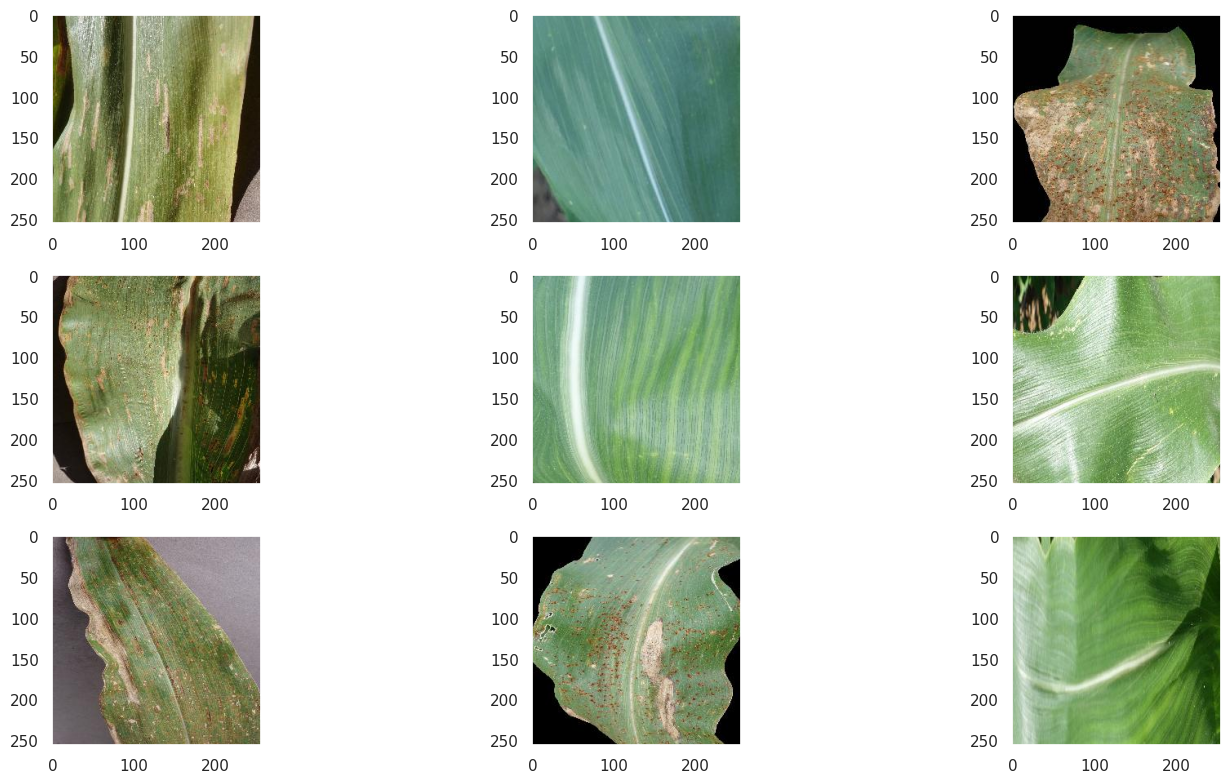

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8))

for ax in axes.flat:
    i = np.random.randint(0, data.shape[0])
    ax.imshow(Image.open(data.loc[i, "Image"]))
    ax.grid(False)

plt.tight_layout()
plt.show()

Train-Test Split:

In [11]:
dev, held_out =train_test_split(
    data,
    train_size=0.8,
    shuffle=True,
    random_state=42)

print(dev.shape)
print(held_out.shape)

(3360, 2)
(841, 2)


Data Preprocessing and Image Data Generators

In [12]:
import keras
from keras.preprocessing import image

Rescaling,Data Augmentation and rescaling

In [13]:
# Rescaling and Data Augmentation
dev_generator = image.ImageDataGenerator(
    rescale=1./224,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

held_generator = image.ImageDataGenerator(rescale=1./224)

Flow from DataFrame:

In [14]:
train_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 2688 validated image filenames belonging to 4 classes.


In [15]:
val_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 672 validated image filenames belonging to 4 classes.


Flow from DataFrame for Testing

In [16]:
held_images = held_generator.flow_from_dataframe(
    dataframe=held_out,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 841 validated image filenames belonging to 4 classes.


In [17]:
labels = train_images.class_indices
labels

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

#MobileNet
This code demonstrates how to perform fine-tuning using the MobileNet model

In [18]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop

The input_shape parameter is set to (150, 150, 3) to match the expected input size.

In [19]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

17225924/17225924 [==============================] - 0s 0us/step


#Freeze the layers in the base model:


#Add custom top layers:


#Create the fine-tuned model:


In [20]:
for layer in base_model.layers:
    layer.trainable = False

# Adding custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Creating the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32)        128   

#Train the model:
The model is trained using the fit method. The training data (train_images) and validation data (val_images) are provided.

In [23]:
history = model.fit(train_images, validation_data=val_images,epochs=50)

Epoch 1/50
84/84 [==============================] - 617s 7s/step - loss: 2.0239 - accuracy: 0.7359 - val_loss: 0.8509 - val_accuracy: 0.8289
Epoch 2/50
84/84 [==============================] - 107s 1s/step - loss: 0.9299 - accuracy: 0.8188 - val_loss: 0.8164 - val_accuracy: 0.8304
Epoch 3/50
84/84 [==============================] - 132s 2s/step - loss: 0.8018 - accuracy: 0.8367 - val_loss: 0.4450 - val_accuracy: 0.8705
Epoch 4/50
84/84 [==============================] - 124s 1s/step - loss: 0.6810 - accuracy: 0.8493 - val_loss: 0.3520 - val_accuracy: 0.8958
Epoch 5/50
84/84 [==============================] - 125s 1s/step - loss: 0.5980 - accuracy: 0.8616 - val_loss: 0.5337 - val_accuracy: 0.8438
Epoch 6/50
84/84 [==============================] - 113s 1s/step - loss: 0.5304 - accuracy: 0.8735 - val_loss: 0.3507 - val_accuracy: 0.8884
Epoch 7/50
84/84 [==============================] - 126s 1s/step - loss: 0.5053 - accuracy: 0.8750 - val_loss: 0.4026 - val_accuracy: 0.8854
Epoch 8/50
84

plotting the graph

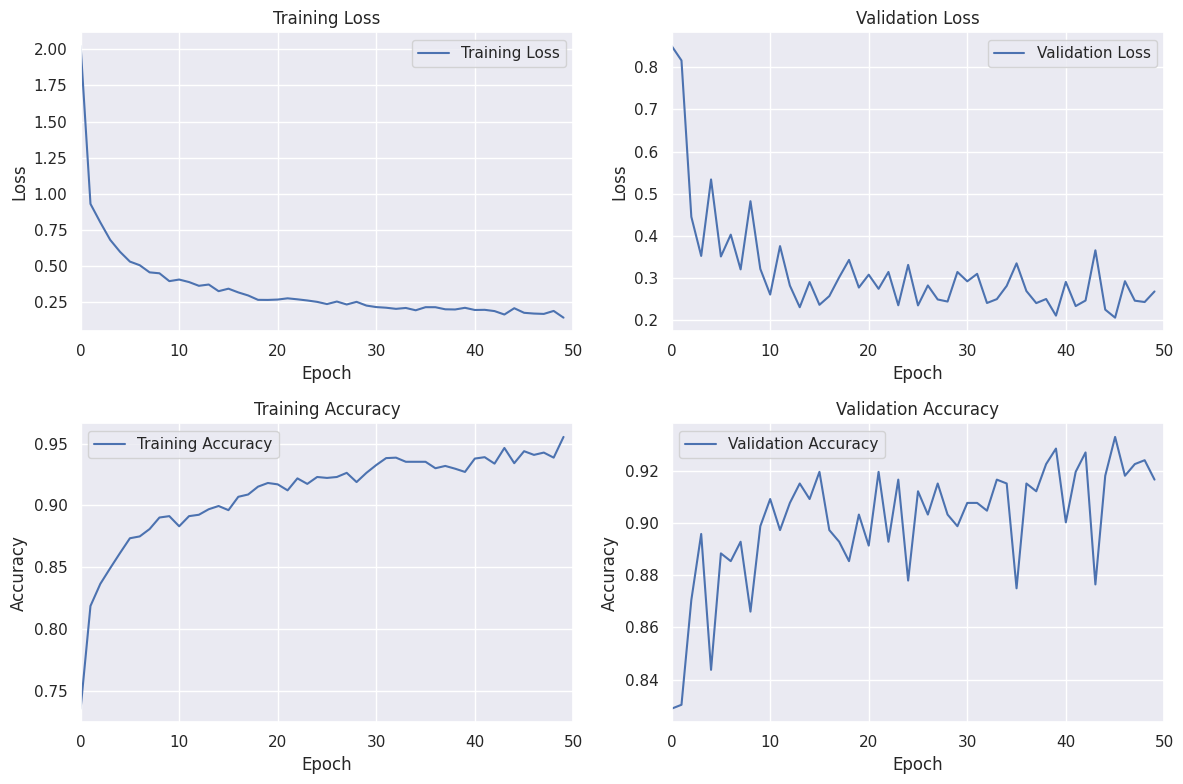

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Ploting training loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_xlim([0, 50])

# Ploting validation loss
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_xlim([0, 50])

# Ploting training accuracy
axes[1, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_xlim([0, 50])

# Ploting validation accuracy
axes[1, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_xlim([0, 50])

plt.tight_layout()
plt.show()

model prediction and evaluation

In [25]:
prediction=model.predict(held_images)


27/27 [==============================] - 151s 6s/step


In [26]:
prediction=np.argmax(prediction, axis=1)
prediction.shape

(841,)

In [27]:
labels = train_images.class_indices
labels = {v: k for k, v in labels.items()}

In [28]:
y_prediction = [labels.get(k) for k in prediction]
y_test = held_out["Quality"].values

accuracy evaluation

In [29]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_prediction))

                precision    recall  f1-score   support

        Blight       0.87      0.94      0.91       253
   Common_Rust       0.98      0.95      0.96       253
Gray_Leaf_Spot       0.82      0.71      0.76       101
       Healthy       1.00      1.00      1.00       234

      accuracy                           0.93       841
     macro avg       0.92      0.90      0.91       841
  weighted avg       0.93      0.93      0.93       841



In [30]:
accuracy_score(y_prediction, y_test)

0.9334126040428062

confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix

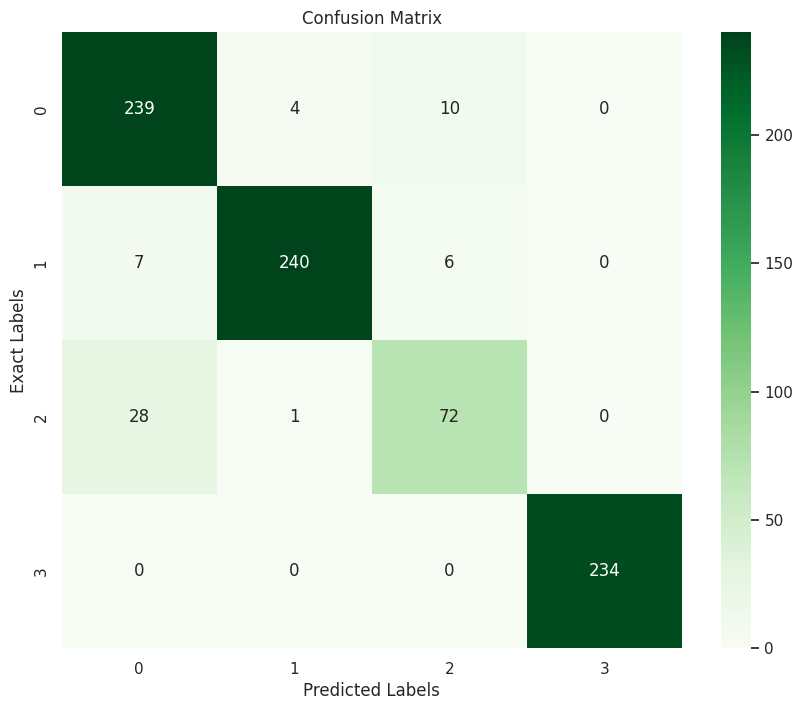

In [32]:
cm = confusion_matrix(y_test, y_prediction)

# Ploting the confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Exact Labels")
plt.show()